In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
import numpy as np
import time
from math import pi
import matplotlib.pyplot as plt
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb

# Clipping

Clipping is the process of extracting subdomains from large spatiotemporal solutions for usage as intial conditions to solve
the same equations. There is an inherent approximation here, as clippings are aperiodic by definition, and typically periodic boundary conditions are in place. The main purpose of clipping is motivated by the idea of shadowing, demonstrated in ```shadowing.ipynb```, but clipping occurs prior to shadowing computations in the spatiotemporal pipeline.

## Large spatiotemporal trajectory clipping.

Clipping is not limited to small orbits; the hypothesis is that orbits are shadowed throughout the entirety of space-time;
therefore we should be able to clip out patches of arbitrary trajectories and use them to find orbits. This can be viewed as an alternative, "more informed" method of producing initial conditions. I think of producing random modulated spectra as
being the "unsupervised" method of generating initial conditions, and clipping is the "supervised" method.

To demonstrate this idea, a large trajectory segment is imported. 

In [2]:
integrated_trajectory = orb.read_h5('./data/OrbitKS.h5', 'trajectory').resize(1024, 1024)
integrated_trajectory.plotting_dimensions()

((0.0, 512.0), (0.0, 57.62024423405479))

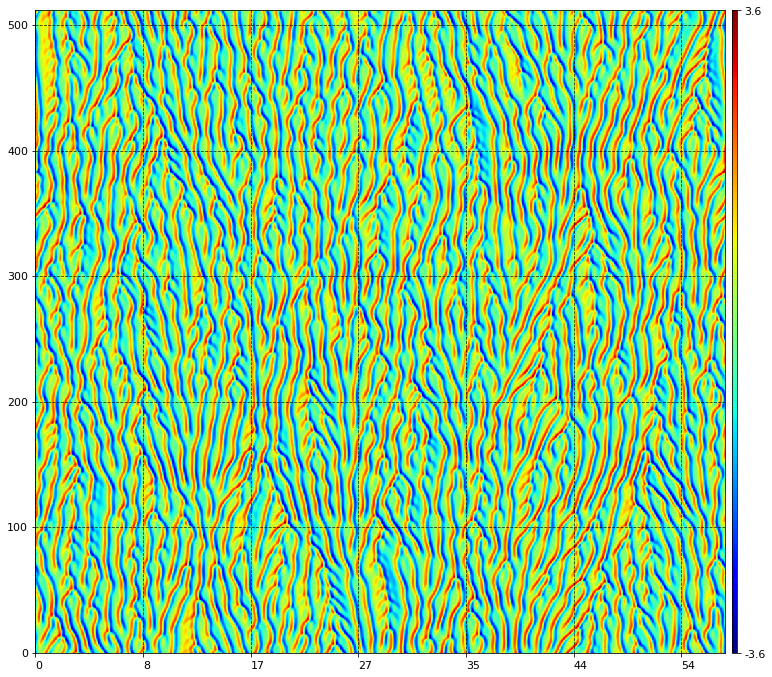

In [3]:
integrated_trajectory.plot()

By far the easiest and most accessible clipping method is implemented via slicing. 

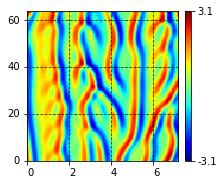

In [4]:
# slice in the field basis to
big_clipping = integrated_trajectory.transform(to='field')[:128, :128]
big_clipping.plot()

In [6]:
big_clipping_result = orb.hunt(big_clipping.transform(to='modes').resize(32, 64), methods=('adj','adj', 'lsmr'),
                           maxiter=[10000, 90000, 1000], preconditioning=[True, False], 
                           ftol=1e-6, verbose=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 62], "basis": "modes", "parameters": [64.0, 64.0, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 11443.46312156765
Target cost tolerance : 1e-06
Maximum iteration number : 100000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=1.4198783 after 5000 adjoint descent steps. Parameters=(64.1121579700615, 64.00000690858818, 0.0)
#################################################
 Residual=0.9914298 after 10000 adjoint descent steps. Parameters=(64.16049055321456, 64.00000712766771, 0.0)
#################################################
 Residual=0.7759971 after 15000 adjoint descent steps. Parameters=(64.19547430157975, 64.00000723071282, 0.0)
#################################################
 Residu

By slicing, the correct *dimensions* are also computed, the `clipping` has dimensions equal to 1/8th of each of `integrated_trajectory`'s dimensions, because 1/8 of the array was sliced.

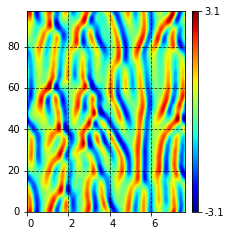

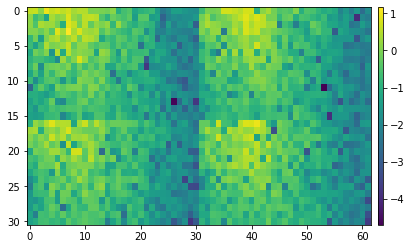

In [11]:
big_clipping_result.orbit.plot(padding=True)
big_clipping_result.orbit.mode_plot()

In [12]:
print(f"The dimensions of the original large spatiotemporal trajectory are {integrated_trajectory.dimensions()}")
print(f"The dimensions of the big_clipping which has 1/8 the points in each dimension are {big_clipping.dimensions()}")
print(f"The ratio of these dimensions are {tuple(cd/itd for cd, itd in zip(big_clipping.dimensions(),integrated_trajectory.dimensions()))}")

The dimensions of the original large spatiotemporal trajectory are (512.0, 512.0)
The dimensions of the big_clipping which has 1/8 the points in each dimension are (64.0, 64.0)
The ratio of these dimensions are (0.125, 0.125)


Next, the region $t\in[200,280], x\in[27,29]$(multiples of $2\pi\sqrt{2}$) is cut out, the interior
and exterior of the clipping can be plotted using numpy array masking; accessible through the ```clipping_mask``` function or providing a mask to `Orbit.mask(mask_array)`
```clipping_mask``` behaves in nearly the same way as ```clip``` except if desired, an iterable of windows can be passed,
in order to show/hide multiple regions of space-time.

The clipping automatically calculates the corresponding field, discretization, parameters. This is designed to work for $d+1$ dimensional spacetime with vector equations, but has yet to be tested for these cases. 

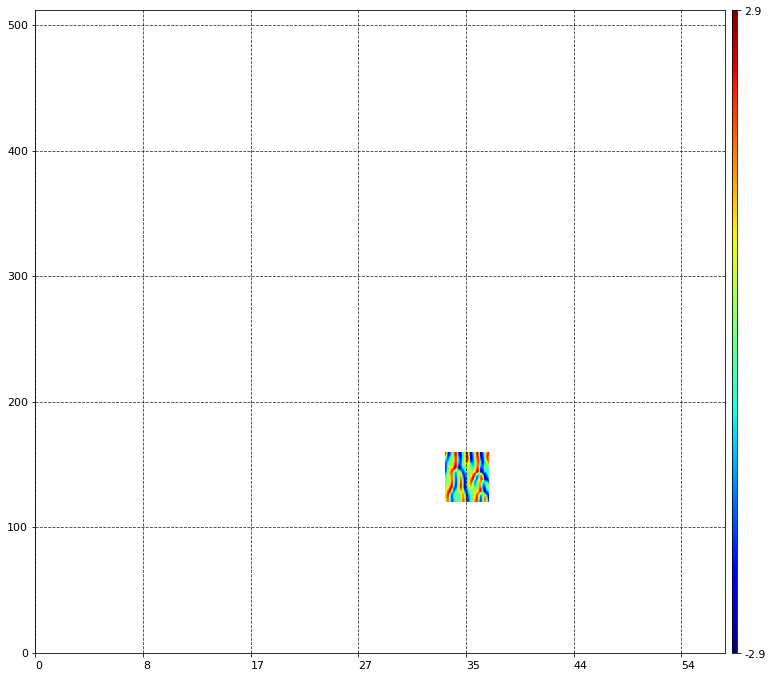

In [13]:
masked_field = orb.clipping_mask(integrated_trajectory,  (((120, 160), (34.25, 38)),), invert=True)
masked_field.plot()

Next, retrieve the actual guess orbit, not its masking, produced from clipping and initialize it as a relative periodic
orbit. The reshaping is simply for reproducibility if default discretization sizes change. 

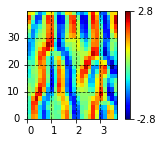

In [14]:
integrated_trajectory = orb.read_h5('./data/OrbitKS.h5', 'trajectory')
clipping = orb.clip(integrated_trajectory,  ((120, 160), (34.25, 38)),
                clipping_class=orb.RelativeOrbitKS).resize(16,16).resize(24, 24)
clipping.populate(attr='parameters')
clipping.plot(fundamental_domain=True)

Note that even though the clipping tiles' spatial domain size was specified to be $2*(2*\pi\sqrt{2})$, the discrete
nature of the problem means that we must take the nearest discrete increment, hence, unless the window boundaries
are separated by a multiple of $L/M$, the clipping will not be returned with the $L$ defined by the boundaries;
also, $N,M$ are required to be even, this might also result in an unexpected size.

Let us pass the clipping to optimization, and see if it converges.

In [16]:
clipping_result = orb.hunt(clipping.transform(to='modes'), methods=('adj', 'lsmr'),
                       maxiter=[100000, 1000], preconditioning=[True, False], ftol=1e-6, pexp=(2, 2), verbose=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [23, 22], "basis": "modes", "parameters": [40.0, 33.0, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 277.0176297327573
Target cost tolerance : 1e-06
Maximum iteration number : 100000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=0.2241660 after 5000 adjoint descent steps. Parameters=(40.00466767932282, 33.0406359811814, 0.0)
#################################################
 Residual=0.1698916 after 10000 adjoint descent steps. Parameters=(40.00494460421067, 33.049298524406694, 0.0)
#################################################
 Residual=0.1405017 after 15000 adjoint descent steps. Parameters=(40.00505751991076, 33.05661239737211, 0.0)
#################################################
 Resid

The resulting orbit is much longer in time, and approximately the same size in space; 

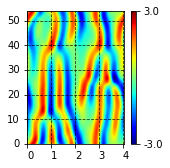

In [55]:
clipping_result.orbit.plot(padding=True)

# Fundamental orbits

Application of the clipping method to the collection of orbits found via numerical optimization
provided us with a handful of fundamental orbits; upon inspection it seems that
only three are unique, the rest lie in the continuous families populated by numerical continuation.

The main reason clipping was developed was to extract fundamental orbits from larger orbits; the fundamental
orbits represent the building blocks of turbulence, as demonstrated in ```gluing_demo.ipynb```. To extract a fundamental
orbit, first identify a pattern defined on a minimal space-time tile; then clip it out and optimize it. It may or may
not take multiple steps, i.e. small clip->optimize-> another small clip, another optimize, etc.

Going by the cost the clipping does indeed exist in the antisymmetric subspace!
By looking at the collection of orbits as well as time integrated trajectories the important patterns were identified
these are denoted as **fundamental periodic orbits**. 

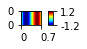

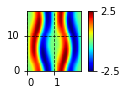

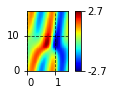

In [54]:
s, w, m = orb.read_h5('./data/tiles.h5', ('default/streak', 'default/wiggle', 'default/defect'))
_ = s.plot(fundamental_domain=False), w.plot(fundamental_domain=False), m.plot()

Let's see how we got these fundamental periodic orbits by clipping. First, identify the pattern we're targeting.
The three patterns above were identified by simply visual scanning of the collection of periodic orbits.

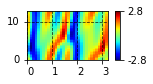

In [47]:
defect_original = orb.read_h5("./data/RelativeOrbitKS.h5", "t12p836_x28p614")
defect_original.plot()

Let's attempt to get the pattern which is approximately between x = 0.8 and 2.2. The space (x) axis is horizontal, time (t) is vertical

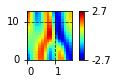


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [15, 14], "basis": "modes", "parameters": [12.836, 14.307, -4.097]})
Constraints : {'t': False, 'x': False, 's': False}
Initial cost : 379.4921796342131
Target cost tolerance : 1e-06
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=0.2340180 after 5000 adjoint descent steps. Parameters=(12.928488237754966, 14.58758690150532, -3.882034879655052)
#################################################
------------------------------------------------------------------------------------------------
Starting lsmr optimization
Initial guess : RelativeOrbitKS({"shape": [15, 14], "basis": "modes", "parameters": [12.98, 14.596, -3.894]})
Constraints : {'t': False, 'x': False, 's': False}
Initial co

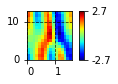

In [48]:
defect_clipping = orb.clip(defect_original.change_reference_frame(frame='physical')
                        , ((None, None),(0.5, 2.2)), frame='physical')
defect_clipping.plot()
defect_clipping = defect_clipping.change_reference_frame(frame='comoving').resize(16, 16).transform(to='modes')

defres = orb.hunt(defect_clipping, methods=('adj', 'lsmr'), preconditioning=True, 
                  pexp=(1,4), verbose=True)

defect_clipping.plot(fundamental_domain=True)

We found the "defect" fundamental periodic orbit. This originally took many attempts because of its nature as being a relative periodic solution, and deficiencies of ancient code that were used to compute this (two years before orbithunter existed).
The idea behind fundamental orbits is that they represent patterns which are shadowed frequently; therefore, if we see small patterns explicitly repeating within a single orbit, we have great candidates for new fundamental orbits!

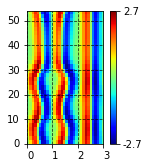

In [49]:
x = orb.read_h5('./data/OrbitKS.h5', 't54p126_x26p744').transform(to='field')
x.plot()

This orbit has a wiggly structure that repeats twice approximately in  $t\in [0, 35]$. Let's target just one of them, as we want the "prime" component. We can do this by iterative clipping, or just simply precise clipping.

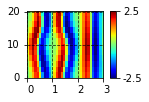

In [50]:
clipped = orb.read_h5('./data/OrbitKS.h5', 't54p126_x26p744').transform(to='field').roll(-2, axis=0)[-12:, :]
clipped.plot()

To get the "wiggle", clip $x\in[0,2]$

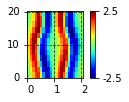


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [11, 10], "basis": "modes", "parameters": [20.298, 18.387, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 97.80394723004743
Target cost tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
####
Converged. Terminating hunt with cost  Terminating hunt with cost = 1.714669372086274e-11


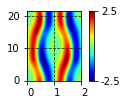

In [51]:
wiggle = clipped[:, :22]
wiggle = orb.AntisymmetricOrbitKS(**vars(wiggle))
wiggle.plot()

wiggle_res = orb.hunt(wiggle.transform(to='modes'), verbose=True, methods='lstsq')
wiggle_res.orbit.plot(padding=True)

But wait; if every region of spacetime is shadowing a periodic orbit, then the remainder of the clipping that we didn't use is an additional guess for a fundamental orbit, an indeed, we are able to find an equilibrium solution therefrom


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : EquilibriumOrbitKS({"shape": [1, 4], "basis": "modes", "parameters": [20.298, 8.358, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 11.224562842597713
Target cost tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#######
Converged. Terminating hunt with cost  Terminating hunt with cost = 4.0775690699662674e-07


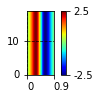

In [52]:
streak = clipped[:, 22:]
streak = orb.EquilibriumOrbitKS(**vars(streak))
streak_res = orb.hunt(streak.transform(to='modes'), verbose=True, methods='lstsq')
streak_res.orbit.plot(padding=True)

The claim is that these represent the fundamental patterns of the Kuramoto-Sivashinsky equation. How fundamental
are these patterns, truly? This is investigated by using yet another spatiotemporal technique: gluing. This is explored in
the notebook `gluing.ipynb`